In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

In [4]:
df_size = 250000
ds = tfds.load('sentiment140', split='train', shuffle_files=True)
df = tfds.as_dataframe(ds.take(df_size))
df.sample(2)

,date,polarity,query,text,user
179646,b'Fri May 01 21:05:41 PDT 2009',4,b'NO_QUERY',"b""I just saw Taylor Swift's new music video 4 ...",b'Kylamvjonasfan'
94779,b'Mon Jun 15 00:14:12 PDT 2009',4,b'NO_QUERY',b'Bk ish was jumpin saw da homie @flyestoncam...,b'image_esh'


In [20]:
len(df)

250000

In [21]:
df['polarity'].value_counts()

4    125116
0    124884
Name: polarity, dtype: int64

---
##### Note: Binary classification can be used. 



In [7]:
df['bin_polarity'] = df['polarity'].apply(lambda x: 1 if x == 4 else 0)

The structure of the RNN is that we take just the output of the final word (unless we're doing a bidirectional format, or a concatenated format where we concatenate the output of all the words)

---

#### Creating X values

The text is in byte form, so we need to convert it to string form, and then use the split functionality to convert to a list. We ignore the first two characters which are a side effect of the conversion, and the last element in the string which is the same

In [22]:
print(f'columns names: {list(df.columns)}')

columns names: ['date', 'polarity', 'query', 'text', 'user', 'bin_polarity', 'split_words', 'txt_length']


In [9]:
## separating the words into a list of words
df['split_words'] = df['text'].apply(lambda x: str(x)[2:].split()[:-1])

In [10]:
## Get the length of words
df['txt_length'] = df['split_words'].apply(lambda x: len(x))

In [11]:
df['txt_length'].value_counts(bins=10)

(5.7, 11.4]      81665
(11.4, 17.1]     61583
(17.1, 22.8]     39162
(-0.058, 5.7]    38476
(22.8, 28.5]     27616
(28.5, 34.2]      1494
(34.2, 39.9]         3
(51.3, 57.0]         1
(45.6, 51.3]         0
(39.9, 45.6]         0
Name: txt_length, dtype: int64

----
Very few tweets are over 30 words, so we will create an RNN based on 30 words

We now need to create a words dictionary

In [12]:
Tx = 30 #this is the value we use to specify how many words to consider in the tweet (first e.g. 30)

In [114]:
'''create words dict'''

no_words = 5000
def create_words_dict(df,no_words):
    
    top_words = list(df['split_words'].explode().value_counts()[:no_words].index)
    word_dict = {}
    for idx, word in enumerate(top_words):
        word_dict[idx+1] = word

    #create additional values for 'word is over' and 'unknown'
    word_dict[no_words+1] = 'word_over'
    word_dict[0] = 'UNKNOWN-WORD'

    #create reversed dict
    word_dict_reversed = {}
    for key, value in word_dict_2k.items():
        word_dict_reversed[value] = key
    
    return word_dict, word_dict_reversed
word_dict_2k, word_dict_reversed = create_words_dict(df,no_words)

---
##### Our X values need to be vocab_size x 30 x m, one hot encoded

In [147]:
#getting the words in numeric index format
    
def create_x_array(df,Tx):
    x = df['split_words'].apply(lambda x: np.array([word_dict_reversed[word] if word in word_dict_reversed.keys() else 0 for word in x]))

    '''we're going to make all the x values the same length'''

    array_x = np.zeros((df_size,Tx)) #blank array to put them in
    for idx,arr in enumerate(x):
        leng = len(arr) 
        #get length, and fork based on current size
        if leng > Tx:
            array_x[idx] = arr[:Tx] #just take first 30 values
        elif leng < Tx:
            array_x[idx] = np.append(arr,np.zeros(Tx-leng)+no_words+1) #append 30 minus the current length -1s
    #put examples on the columns
    array_x = array_x.T
    return array_x,x


array_x,x = create_x_array(df,Tx=30)

In [148]:
array_x.shape

(30, 250000)

In [87]:
'''Now one hot encode them'''
def one_hot_process(array_x,Tx, batch_size):
    one_hot_x_40k = np.zeros((no_words+2,Tx,batch_size))
    for row_idx, row in enumerate(array_x[:,:batch_size]):
        for exam_idx, word_val in enumerate(row):
            one_hot_x_40k[int(word_val),row_idx,exam_idx] = 1
    return one_hot_x_40k
def mask_process(array_x, batch_size):
    return np.where(array_x[:,:batch_size]==no_words+1,1,0)
def one_hot_and_mask(array_x, Tx, batch_size):
    one_hot_x_40k = one_hot_process(array_x,Tx, batch_size)
    mask_x = mask_process(array_x, batch_size)
    return one_hot_x_40k, mask_x

In [52]:
one_hot_x_40k = one_hot_process(array_x,Tx, 10000)


---
We've used 2002 in order to incorporatate the 2001th word (end of word) and unknown index. We can need to create a mask which tells the machine to skip if the mask is positive

In [143]:
mask_x  = mask_process(array_x, 10000)

In [144]:
mask_x.shape

(30, 10000)

In [ ]:
#Turn Y into an array
Y = np.array(reduced_df['bin_polarity']).reshape(1,-1)

----
OK so we have our x inputs. Mask x, shaped 30 x 40000, and the actual onehotencoded x values, of shape 2001, 30, 40000

In the basic RNN, ignoring the last stage for a second, each cell has three weights matrixes.

### Forward Prop

WAa - the weights applied to the previous cells outputs

WAx - the weights applied to the X values

WaB - a bias term. 

We have to make a choice of how large each cell is, and then initialise the weights. We'll use a Xavier initialization for now

In [40]:
#try a cell size of 50
cell_size = 50
x_size = no_words+no_words #Xavier_initialization of weights.
WAa = np.random.uniform(-(6)/(np.sqrt(cell_size*2)),(6)/((cell_size*2)),[cell_size,cell_size]) 
WAb = np.random.uniform(-(6)/(np.sqrt(cell_size+1)),(6)/((cell_size+1)),[cell_size,1]) 
WAx = np.random.uniform(-(6)/(np.sqrt(cell_size+x_size)),(6)/((cell_size+x_size)),[cell_size,x_size]) 

#We need a weights matrix too for later
WYa = np.random.uniform(-(6)/((cell_size+1)),(6)/((cell_size+1)),[1,cell_size])
WYb = np.random.uniform(-(6)/((1+1)),(6)/((1+1)),[1,1])

weights_dict = {}
weights_dict['WAa'] = WAa
weights_dict['WAb'] = WAb
weights_dict['WAx'] = WAx
weights_dict['WYa'] = WYa
weights_dict['WYb'] = WYb


---
Now let's implement one run of forward prop in order to replicate it going forward

In [41]:
#these allow us to set some default values
a0 = np.zeros((cell_size,df_size))
z_dict, a_dict = {}, {}
a_dict[0] = a0

In [42]:
'''See notes from above - this is just implemented as a function'''
def forward_prop(a_prev,  WAa, WAx, WAb, x, mask,time_period=0):
    
    # #z1 - the pre-tanh values of a0, bias and x1 times weights
    z1 = WAa @ a_prev + WAx @ x[:,time_period,:] + WAb
    
    # #a1 either equals a1 if mask ==1 or equal tanh z1 if mask == - 
    a1 = mask[time_period].reshape(1,-1) * a_prev + (1-mask[time_period]) * np.tanh(z1)
    
    return a1, z1

---
The idea here is to loop over the time periods and run forward prop each time. We will need to re-use a1 and z1 when we come back and do the back prop, so we will store them in a dictionary

In [43]:
def cells_fw_prop(Tx, z_dict, a_dict, a0,WAa, WAx, WAb, x, mask):
    a_prev = a0 #to have an initial value to call the forward_prop function
    for i in range(Tx):
        a_, z_ = forward_prop(a_prev=a_prev, time_period = i,x=x,mask = mask,WAa=WAa, WAx=WAx, WAb=WAb)
        z_dict[i+1], a_dict[i+1] = z_, a_
        a_prev = a_
    #we end by returning the dictionary for z and a values throughout the time period
    return z_dict, a_dict 

---
##### Lets put it all together in a forward prop function

In [57]:
def sigmoid(Yz):
        return (1/(1+np.exp(-Yz)))
    
def full_fw_prop(weights_dict, z_dict, a_dict, x, mask, Tx = Tx):
    
    # initialize a0 and dict values
    a0 = np.zeros((cell_size, x.shape[2]))
    a_dict[0] = a0
    WAa, WAb, WAx, WYa, WYb = weights_dict.values()

    #do the cell forward prop    
    z_dict, a_dict = cells_fw_prop(Tx = Tx, z_dict=z_dict, a_dict=a_dict, a0=a0,WAa=WAa, WAx=WAx, WAb=WAb, x=x,mask=mask)

    #extract last value and prediction
    final_a = a_dict[Tx]
    Yz = WYa @ final_a + WYb
   
    Ÿ = sigmoid(Yz)

    return z_dict, a_dict, Yz, Ÿ

----
### Back Propogation

We can conveniently use the differentiated sigmoid function, which gives

DL/DZ = Ÿ - Y

From there we can initially back calculate the values of the final portion, giving values for DL/DA, DL/DWYa, DL/DWYb

In [45]:
#Turn Y into an array
Y = np.array(reduced_df['bin_polarity']).reshape(1,-1)

In [46]:
#let's start by initializing the backprop dicts
dA_dict, dZ_dict = {}, {}

---
OK let's create the relevant functions

In [47]:
def back_prop_one_layer(prev_Loss, t, weights_dict,  a_dict,z_dict,  X, mask_x,learning_rate = 0.01,batch_size=400):
    
    WAa, WAb, WAx, WYa, WYb = weights_dict.values()
    a_ = a_dict[t]
    z_ = z_dict[t]
    a__ = a_dict[t-1]
    x_ = X[:,t-1,:]

    #get dA and dZ as a base for the layer
    dL_dA = prev_Loss #40000,50
    dA_dZa = ((1-mask_x[t-1]) * (1-(np.tanh(z_)**2))).T #40000,50
    
    #get a previous
    dZ_dAp = WAa #50x50
    dA_dAp = mask_x[t-1].reshape(-1,1) + np.zeros_like((dL_dA)) + (dA_dZa @ dZ_dAp) #we create a mask of 1s everywhere here.
    dL_dAp = dL_dA * dA_dAp

    #differentiate with respect to weights
    dZ_dWAa = a__ #50 x m
    dL_dWAa = ((dL_dA * dA_dZa).T @ dZ_dWAa.T)/batch_size #weights dont matter if we are having a 0 on the mask

    dZ_dWAb = np.zeros((batch_size,1))+1
    dL_dWAb = ((dL_dA * dA_dZa).T @ dZ_dWAb)/batch_size

    dZ_dWAx = x_
    dL_dWAx = ((dL_dA * dA_dZa).T @ dZ_dWAx.T)/batch_size #weights dont matter if we are having a 0 on the mask
    
    #now update the weights based on the findings here.
    return dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp

In [49]:
def back_prop_full_swing(Ÿ, Y, Tx, weights_dict,  a_dict,z_dict,  X, mask_x,learning_rate = 0.01,batch_size = 100):
    
    '''initial loss function w.r.t Z'''
    WAa, WAb, WAx, WYa, WYb = weights_dict.values()
    dL_dZ = (Ÿ - Y).T #40000 x 1


    # first order diffs
    dZ_dA = WYa # 1 x 50
    dZ_dWYa = a_dict[Tx] # 50 x 40000
    dZ_dB = np.zeros_like(dL_dZ) + 1

    #chain ruled diffs
    dL_dA = dL_dZ @ dZ_dA
    dL_dWYa = (dZ_dWYa @ dL_dZ).T / batch_size
    dL_dWYb = (dZ_dB.T @ dL_dZ)/ batch_size
    
    weights_dict['WYa'] -= learning_rate * dL_dWYa
    weights_dict['WYb'] -= learning_rate * dL_dWYb
    
    prev_loss = dL_dA
    '''now go through the other functions'''
    for t in reversed(range(1,Tx)):
        #extract relevant differentials for updating backprop and also carrying on the backprop through the layers
        dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp = back_prop_one_layer(prev_Loss=prev_loss, t=t, weights_dict = weights_dict,X=x,  a_dict=a_dict,z_dict=z_dict,mask_x=mask_x,batch_size=batch_size)
        weights_dict['WAa'] -= learning_rate*dL_dWAa
        weights_dict['WAx'] -= learning_rate*dL_dWAx
        weights_dict['WAb'] -= learning_rate*dL_dWAb
        prev_loss = dL_dAp
        return dL_dZ, dZ_dA, dZ_dB, dL_dA, dL_dWYa, dL_dWYb, dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp

In [50]:
# back_prop_full_swing(Ÿ=Ÿ, Y=Y, Tx=Tx, weights_dict=weights_dict,  a_dict=a_dict,z_dict=z_dict,  X=one_hot_x_40k, mask_x=mask_x,learning_rate = 0.01)

---

#### Putting it all together

Let's now create a function which runs forward prop and backward prop in batches, and calculates the loss at each time

In [ ]:
'''set some initial parameters'''
epochs = 2001
cell_size = 200
x_size = no_words+2

''' initialize weights'''

WAx = np.random.uniform(-1,1,[cell_size,x_size])
WAb = np.random.uniform(-1,1,[cell_size,1])
WAa = np.random.uniform(-0.1,0.1,[cell_size,cell_size])
WYa = np.random.uniform(-0.25,0.25,[1,cell_size])
WYb = np.random.uniform(-1,1,[1,1])

weights_dict = {}
weights_dict['WAa'] = WAa
weights_dict['WAb'] = WAb
weights_dict['WAx'] = WAx
weights_dict['WYa'] = WYa
weights_dict['WYb'] = WYb

'''define additional dictionaries and characteristics'''
z_dict, a_dict = {}, {}
losses = []
accs = []
batches=2000
batch_size = int(df_size//batches) #so 400

for epoch in range(epochs):
    #run fw prop
    '''create batching'''
    

    ''' This sections deals with batching'''
    
    round_ = epoch % batches #deals with if it's the first of a new set of batches
    n, k = batch_size*round_, batch_size*(1 + round_)
    x = one_hot_x_40k[:,:,n:k]
    mask_x_ = mask_x[:,n:k]
    y = Y[0,n:k]
    
    '''Forward prop'''
    z_dict, a_dict, Yz, Ÿ = full_fw_prop(Tx = Tx, z_dict=z_dict, a_dict=a_dict, weights_dict = weights_dict, x=x,mask=mask_x_)
    '''create loss metrics for reporting'''
    loss = -np.sum(y*np.log(Ÿ) + (1-y)*np.log(1-Ÿ))/batch_size
    accuracy = np.sum(y==np.where(Ÿ>0.5,1,0))/batch_size
    losses.append(loss)
    accs.append(accuracy)
    if epoch % 200 == 0:
        print(f'Accuracy score: {np.mean(accs[(epoch-batch_size):])}')    
        print(f'Epoch: {epoch}, loss: {loss}')
    
    #run backprop
    dL_dZ, dZ_dA, dZ_dB, dL_dA, dL_dWYa, dL_dWYb, dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp = back_prop_full_swing(Ÿ=Ÿ, Y=y, Tx=Tx, weights_dict=weights_dict,  a_dict=a_dict,z_dict=z_dict,  X=x, mask_x=mask_x_,learning_rate = 0.1,batch_size = batch_size)

Accuracy score: 0.41333333333333333
Epoch: 0, loss: 0.8744233243901126
Accuracy score: 0.5210526315789474
Epoch: 200, loss: 0.6743788061355299
Accuracy score: 0.5291228070175439
Epoch: 400, loss: 0.6454877514690217
Accuracy score: 0.5456140350877193
Epoch: 600, loss: 0.6587351042883004
Accuracy score: 0.5505263157894738
Epoch: 800, loss: 0.6892139057242007


In [1]:
a_dict

NameError: name 'a_dict' is not defined

---
We see a small amount of ability from the model to predict sentiment.

#### GRU

We'll use the same format, albeit with different functions to build a GRU

In [65]:
'''Weights initialisation'''
def weights_initialisation(batch_size,cell_size=50,x_size=2002):
    #initialise the weights for the main 'estimator' node
    weights={}
    weights['gWCx'] = np.random.uniform(-1,1,[cell_size, x_size])
    weights['gWCc'] = np.random.uniform(-1,1,[cell_size, cell_size])
    weights['gWCb'] = np.random.uniform(-1,1,[cell_size,1])

    #initialize weights for the 'update' node
    weights['gWUx'] = np.random.uniform(-1,1,[cell_size, x_size])
    weights['gWUc'] = np.random.uniform(-1,1,[cell_size, cell_size])
    weights['gWUb'] = np.random.uniform(-1,1,[cell_size,1])

    #initalise weights for output layer
    weights['gWYa'] = np.random.uniform(-0.25,0.25,[1,cell_size])
    weights['gWYb'] = np.random.uniform(-1,1,[1,1])
    
    a0 = np.zeros((cell_size, batch_size)) #create blank a0
    return weights, a0

def dict_initialisation_gru():
    zc_dict, zu_dict, č_dict, cupd_dict, c_dict = {}, {}, {}, {}, {}
    return zc_dict, zu_dict, č_dict, cupd_dict, c_dict

In [88]:
def gforward_prop_1(c_prev, weights, x, mask, t=0):
    gWCx, gWCc, gWCb, gWUx, gWUc, gWUb, _, _ = weights.values()
    
    #create value for č by creating a z value to be tanhd + b
    
    zc = gWCx @ x[:,t,:] + gWCc @ c_prev + gWCb
    č = np.tanh(zc)
    
    #now create a value for c_update, and use mask to make this 0 if the mask is on.
    zu = gWUx @ x[:,t,:] + gWUc @ c_prev + gWUb 
    Cupd = (1-mask[t]) * sigmoid(zu) #this will be zero if mask is 1
    
    #now update c
    c = Cupd * č + (1-Cupd) * c_prev
    
    return zc, č, zu, Cupd, c

In [48]:
def gcells_fw_prop(zc_dict, zu_dict, č_dict, cupd_dict, c_dict, a0, weights, x, mask,Tx):
    
    c_prev = a0 #to have an initial value to call the forward_prop function
    for t in range(Tx):
        zc, č, zu, Cupd, c = gforward_prop_1(c_prev=c_prev, t = t,x=x,mask = mask, weights=weights)
        zc_dict[t+1], č_dict[t+1], zu_dict[t+1], cupd_dict[t+1], c_dict[t+1] = zc, č, zu, Cupd, c
        c_prev = c
    #we end by returning the dictionary for z and a values throughout the time period
    return zc_dict, zu_dict, č_dict, cupd_dict, c_dict

In [58]:
def gfull_fw_prop(a0, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x, mask, Tx = Tx):
    
    #do the cell forward prop    
    zc_dict, zu_dict, č_dict, cupd_dict, c_dict = gcells_fw_prop(zc_dict, zu_dict, č_dict, cupd_dict, c_dict, a0, weights, x, mask,Tx)

    #extract last value and prediction
    final_c = c_dict[Tx]
    Yz = weights['gWYa'] @ final_c + weights['gWYb']
    Ÿ = sigmoid(Yz)

    return zc_dict, zu_dict, č_dict, cupd_dict, c_dict, Yz, Ÿ

In [59]:
def sigmoid(Yz):
        return (1/(1+np.exp(-Yz)))

---

#### unit tests

In [51]:
one_hot_x_40k

(5002, 30, 10000)

In [66]:
#when i initialise the weights, with a different x size, gWCx gives that value. same with cell size
x_size_ut = 5002
c_size_ut = 50
batch_size= 1000
x_ut, mask_x_ut = one_hot_x_40k[:,:,:batch_size], mask_x[:,:batch_size]
y_ut = Y[:,:batch_size]

weights_ut,a0= weights_initialisation(cell_size=c_size_ut,x_size=x_size_ut,batch_size=batch_size)
assert weights_ut['gWUx'].shape == (c_size_ut, x_size_ut)

#when i call the main function, c_dict[30] should be numbers with mean ~ 0 and var [0.25,1.25]
zc_dict, zu_dict, č_dict, cupd_dict, c_dict = dict_initialisation_gru()
zc_dict, zu_dict, č_dict, cupd_dict, c_dict, Yz, Ÿ = gfull_fw_prop(a0, weights_ut, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x_ut, mask_x_ut, Tx)

assert abs(np.mean(c_dict[30])) < 0.1
assert 0.25 < np.var(c_dict[30]) < 1.25

print(f'Mean: {np.mean(c_dict[30])}\nVariance: {np.var(c_dict[30])}')

Mean: 0.005293171860522315
Variance: 0.5036911379840215


---
Alright now we're burning diesel.

Time for back prop...

In [61]:
def gback_prop_one_layer(prev_loss, t, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict,  x, mask_x,learning_rate = 0.01,batch_size=400):
    
    gWCx, gWCc, gWCb, gWUx, gWUc, gWUb, gWYa, gWYb = weights.values()
    zc, zu, č, cupd, c = zc_dict[t], zu_dict[t], č_dict[t], cupd_dict[t], c_dict[t]
    c_ = c_dict[t-1] #also take the last c value frm previous round for differentials
    x_ = x[:,t-1,:] #relevant x values, 2000 x m

    dl_dc = prev_loss #m,50

    '''first backpropogate through to get c previous'''
    dc_dč = cupd #50 x m 
    dc_dcupd = č - c_ #50 x m
    dč_dzc = 1 - np.tanh(zc)**2 #50 x m
    dcupd_dzu = sigmoid(zu) * (1-sigmoid(zu)) #50 x m
    dzc_dc_1 = gWCc #50,50
    dzu_dc_1 = gWUc #50,50

    #1- cupd is 50, m
    dc_dc_1 = (1-cupd).T + ((dc_dč * dč_dzc).T @ gWCc) + ((dc_dcupd * dcupd_dzu).T @ gWUc) #ends as 50 x m 
    dl_dc_1 = dl_dc * dc_dc_1 #m x 50

    
    '''now get the weights with respect to L'''
    #first three terms are element wise because they are the ru term and the sigmoid term.

    dL_dWCx = (dl_dc.T * dc_dč * dč_dzc) @ x_.T #50 x m, m x 2000 = 50 x 2000 (same shape as WCx)
    dL_dWCb = ((dl_dc.T * dc_dč * dč_dzc) @ (np.zeros((batch_size,1))+1))/batch_size #50 x m, m x 1 = 50 x1
    dL_dWCc = (dl_dc.T * dc_dč * dč_dzc) @ c_.T #50 x m, m x 50 = 50 x 50
    dL_dWUx = (dl_dc.T * dc_dcupd * dcupd_dzu) @ x_.T
    dL_dWUb = ((dl_dc.T * dc_dcupd * dcupd_dzu) @ (np.zeros((batch_size,1))+1))/batch_size #50 x m, m x 1 = 50 x1
    dL_dWUc = (dl_dc.T * dc_dcupd * dcupd_dzu) @ c_.T #50 x m, m x 50 = 50 x 50
    return dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1

In [62]:
x_ut.shape

(5002, 30, 1000)

In [69]:
def gback_prop_full_swing(Ÿ, Y, Tx, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x, mask_x,learning_rate = 0.01,batch_size = 100):
    
    '''initial loss function w.r.t Z'''
    gWCx, gWCc, gWCb, gWUx, gWUc, gWUb, gWYa, gWYb = weights.values()
    dL_dZy = (Ÿ - Y).T #40000 x 1

    # first order diffs
    dZ_dC = gWYa # 1 x 50
    dZ_dWYa = c_dict[Tx] # 50 x 40000
    dZ_dB = np.zeros_like(dL_dZy) + 1

    #chain ruled diffs
    dL_dC = dL_dZy @ dZ_dC
    dL_dWYa = (dZ_dWYa @ dL_dZy).T / batch_size
    dL_dWYb = (dZ_dB.T @ dL_dZy)/ batch_size
    
    #update end weights.
    weights['gWYa'] -= learning_rate * dL_dWYa
    weights['gWYb'] -= learning_rate * dL_dWYb
    
    prev_loss = dL_dC
    '''now go through the other functions'''
    for t in reversed(range(1,int(Tx))):
        #extract relevant differentials for updating backprop and also carrying on the backprop through the layers
        dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1 = gback_prop_one_layer(prev_loss, t, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict,  x, mask_x,learning_rate = 0.01,batch_size=batch_size)
        weights['gWCx'] -= learning_rate*dL_dWCx
        weights['gWCc'] -= learning_rate*dL_dWCc
        weights['gWCb'] -= learning_rate*dL_dWCb
        weights['gWUx'] -= learning_rate*dL_dWUx
        weights['gWUc'] -= learning_rate*dL_dWUc
        weights['gWCb'] -= learning_rate*dL_dWUb
        prev_loss = dl_dc_1
        return dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1, dL_dWYa,dL_dWYb, dL_dZy

---
Unit tests

Manual: check that the top 4 values are 10%+ different versus the bottom 2

In [70]:
print(np.sum(weights_ut['gWCx']),np.sum(weights_ut['gWYa']))
print(np.var(weights_ut['gWCx']),np.var(weights_ut['gWYa']))
for i in range(10):
    dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1, dL_dWYa,dL_dWYb, dL_dZy = gback_prop_full_swing(Ÿ, y_ut, Tx, weights_ut, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x_ut, mask_x_ut,learning_rate = 0.1,batch_size = 1000)
print(np.sum(weights_ut['gWCx']),np.sum(weights_ut['gWYa']))
print(np.var(weights_ut['gWCx']),np.var(weights_ut['gWYa']))

216.88170927233705 0.274305851214951
0.33313811546797917 0.0192547977943042
216.69760353753261 0.21641270161579887
0.3331392838193671 0.02130430017008906


---
Putting it all together with the GRU

In [94]:
batches

1000

In [161]:
#set epochs, cell_size, x_size (from no_words)
epochs = 50
cell_size= 300
voc_siz = no_words+2
batch_size = 250
lr = 0.05

def gru_train(epochs, cell_size, voc_size,batch_size,no_words,lr, Y, array_x, Tx):
    # initialize weights
    weights,a0= weights_initialisation(cell_size=cell_size,x_size=voc_siz,batch_size=batch_size)
    zc_dict, zu_dict, č_dict, cupd_dict, c_dict = dict_initialisation_gru()

    #create loss & accuracy lists
    glosses = []
    gaccs = []

    #create batches
    batches = int(df_size//batch_size)
    for epoch in range(epochs):
        #create batch of x, x mask and y
        round_ = epoch % batches 
        n, k = batch_size*round_, batch_size*(1 + round_)
        x, mask_x_ = one_hot_and_mask(array_x[:,n:k],Tx,batch_size)
        y = Y[0,n:k]

        #forward prop and loss calculation
        zc_dict, zu_dict, č_dict, cupd_dict, c_dict, Yz, Ÿ = gfull_fw_prop(a0, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x, mask_x_, Tx)
        '''create loss metrics for reporting'''
        loss = -np.sum(y*np.log(Ÿ) + (1-y)*np.log(1-Ÿ))/batch_size
        accuracy = np.sum(y==np.where(Ÿ>0.5,1,0))/batch_size
        glosses.append(loss); gaccs.append(accuracy)
        if epoch % 200 == 0:
            print(f'Accuracy score: {np.mean(gaccs[(epoch-batch_size):])}')    
            print(f'Epoch: {epoch}, loss: {loss}')

        #back prop
        dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1, dL_dWYa,dL_dWYb, dL_dZy = gback_prop_full_swing(Ÿ, y, Tx, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x, mask_x,learning_rate = lr,batch_size = batch_size)
    
    return glosses, gaccs, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, Yz, Ÿ, dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1, dL_dWYa,dL_dWYb, dL_dZy



In [ ]:
tuple_of_outcomes = gru_train(epochs, cell_size, voc_siz,batch_size,no_words,lr, Y, array_x, Tx)

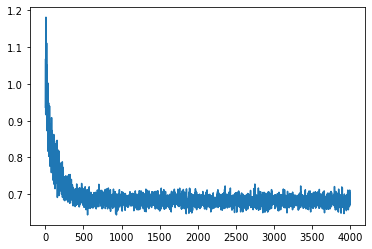

In [101]:
import matplotlib.pyplot as plt
plt.plot(glosses)

In [141]:
reduced_df.sample(5)

,date,polarity,query,text,user,bin_polarity,split_words,txt_length
189562,b'Wed Jun 03 02:05:40 PDT 2009',0,b'NO_QUERY',b'@Shikha_M yeah do...but its hacked ',b'Pro_94JBIT',0,"[@Shikha_M, yeah, do...but, its, hacked]",5
75941,b'Mon Jun 15 15:14:00 PDT 2009',0,b'NO_QUERY',b'@radadams Do want ',b'Mayeh',0,"[@radadams, Do, want]",3
88864,b'Sun Jun 21 01:14:59 PDT 2009',0,b'NO_QUERY',"b""I don't get it at all """,b'jodeeluv',0,"[I, don't, get, it, at, all]",6
39095,b'Fri May 29 12:41:21 PDT 2009',4,b'NO_QUERY',b'@PixyStixKitten The Last Unicorn...one of my...,b'rangerlyn',1,"[@PixyStixKitten, The, Last, Unicorn...one, of...",7
157169,b'Sat Jun 06 22:57:06 PDT 2009',4,b'NO_QUERY',b'listening to anberlin and passsing out ',b'ticklemexmik',1,"[listening, to, anberlin, and, passsing, out]",6


--
##### Struggling to get a strong signal, but it's worth noting that a lot of the comments are difficult to classify even for a human 

Let's try another datase

In [123]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=False)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [126]:
df2 = tfds.as_dataframe(train_dataset.take(df_size))

In [131]:
df2.columns

Index(['label', 'text'], dtype='object')

In [132]:
df2.head(3)

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...


In [158]:
no_words_mov = 5000
## split words
df2['split_words'] = df2['text'].apply(lambda x: str(x)[2:].split()[:-1])

#create dictionary
word_dict_mov, word_dict_reversed_mov = create_words_dict(df2,no_words_mov)

#create x values
array_x_mov,x_mov = create_x_array(df2,Tx_mov)

#Turn Y into an array
Y_mov = np.array(df2['label']).reshape(1,-1)

In [139]:
epochs_mov = 2000 #5000
lr_mov = 0.05
batch_size_mov = 250
cell_size_mov = 200
Tx_mov = 40

In [ ]:
tuple_of_outcomes_mov = gru_train(epochs_mov, cell_size_mov, no_words_mov,batch_size_mov,no_words,lr_mov, Y_mov, array_x_mov, Tx_mov)

Accuracy score: 0.5
Epoch: 0, loss: 1.1288098771217552


In [159]:
x__, mask_x___ = one_hot_and_mask(array_x_mov[:,n:k],Tx_mov,batch_size_mov)

In [160]:
mask_x___.shape

(40, 250)